In [19]:
import json
import glob
import os
import pandas as pd
# import a library for string similarity calculation
from fuzzywuzzy import fuzz
import random
import string


/Users/cl3720/Desktop/Doc2Hpo2.0/back-end/.venv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [31]:
# function to calculate string similarity
def string_similarity(s1, s2):
    # generate a random string with same length of s2
    # s2_random = ''.join(random.choices(string.ascii_letters, k=len(s2)))
    # bootstrap the string similarity calculation for s2_random and s1 for 100 times
    # ci = [fuzz.ratio(s1, s2_random) for i in range(100)]
    # calculate the 95% confidence interval
    # ci_lower = pd.Series(ci).quantile(0.025)
    # ci_upper = pd.Series(ci).quantile(0.975)
    # calculate the string similarity for s1 and s2
    sim = fuzz.ratio(s1, s2)
    return sim

In [36]:
json_list = glob.glob('./simulated_pt_coordinate/*.json')
rows = []
shift_chars = range(-10, 10)
for shift_char in shift_chars:
    print(f'shift_char: {shift_char}')
    for json_file in json_list:
        with open(json_file, 'r') as f:
            id = os.path.basename(json_file).split('.')[0]
            data = json.load(f)
            text = data['response']
            if 'gpt' in data['matched_hpo']:
                terms = data['matched_hpo']['gpt']['terms']
                intervals = data['matched_hpo']['gpt']['intervals']
            for i in range(len(terms)):
                # check if the len of the term equals to the len of the interval
                if len(terms) != len(intervals):
                    raise ValueError('The length of terms and intervals are not equal.') 
                start = intervals[i][0] + shift_char
                end = intervals[i][1] + shift_char
                rows.append([id, terms[i], intervals[i], text[start:end]])
    df = pd.DataFrame(rows, columns=['id', 'term', 'interval', 'snippet'])   
    df['term_length_vs_interval_length'] = df.apply(lambda x: len(x['term']) / (x['interval'][1] - x['interval'][0]), axis=1)
    # percentage of terms that have a term length vs interval length ratio equal to 1 with 2 decimal places
    print(f'Ratio of terms that have a term length vs interval length ratio equal to 1: {len(df[df["term_length_vs_interval_length"] == 1]) / len(df) * 100:.2f}%')
    df['string_similarity'] = df.apply(lambda x: string_similarity(x['term'], x['snippet']), axis=1)
    print(f'Median string similarity: {df["string_similarity"].median()}')

shift_char: -10
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87%
Median string similarity: 23.0
shift_char: -9
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87%
Median string similarity: 23.0
shift_char: -8
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87%
Median string similarity: 23.0
shift_char: -7
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87%
Median string similarity: 23.0
shift_char: -6
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87%
Median string similarity: 23.0
shift_char: -5
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87%
Median string similarity: 23.0
shift_char: -4
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87%
Median string similarity: 23.0
shift_char: -3
Ratio of terms that have a term length vs interval length ratio equal to 1: 13.87

In [46]:
# for those terms also appeared in 'ac'
# compare the interval distance between 'gpt' and 'ac'
json_list = glob.glob('./simulated_pt_coordinate/*.json')
rows = []
for json_file in json_list:
    with open(json_file, 'r') as f:
        id = os.path.basename(json_file).split('.')[0]
        data = json.load(f)
        text = data['response']
        if 'gpt' in data['matched_hpo']:
            terms_gpt = data['matched_hpo']['gpt']['terms']
            intervals_gpt = data['matched_hpo']['gpt']['intervals']
        if 'ac' in data['matched_hpo']:
            terms_ac = data['matched_hpo']['ac']['terms']
            intervals_ac = data['matched_hpo']['ac']['intervals']
        for i in range(len(terms_gpt)):
            for j in range(len(terms_ac)):
                if terms_gpt[i].lower() == terms_ac[j].lower():
                    rows.append([id, terms_gpt[i], intervals_gpt[i], intervals_ac[j], abs(intervals_gpt[i][0] - intervals_ac[j][0]), abs(intervals_gpt[i][1] - intervals_ac[j][1])])
df = pd.DataFrame(rows, columns=['id', 'term', 'interval_gpt', 'interval_ac', 'distance_start', 'distance_end'])
# for same id, and term only retain the one with smalled distance_start
df.groupby(['id', 'term']).apply(lambda x: x[x['distance_start'] == x['distance_start'].min()]).reset_index(drop=True)


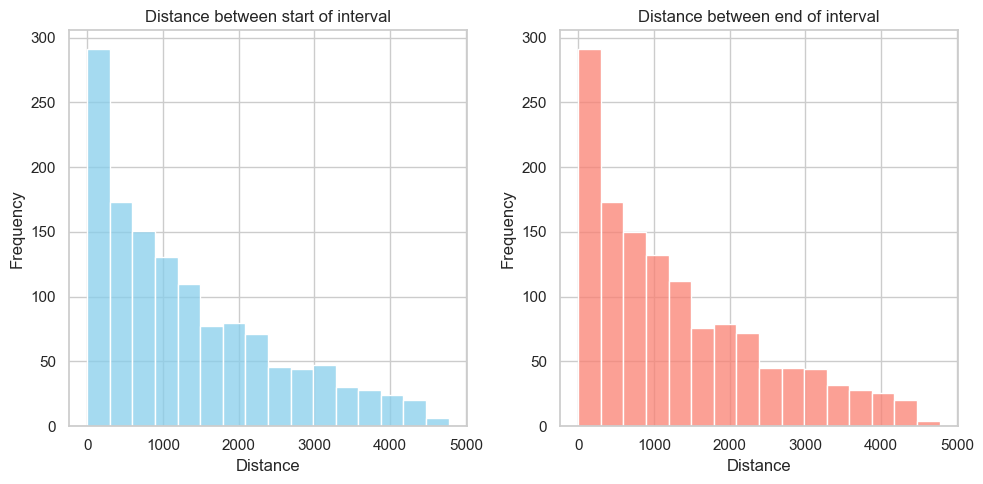

In [59]:
# plot the distance between 'gpt' and 'ac' for the same term
# plot start and end seperately with different colors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(df['distance_start'], ax=ax[0], color='skyblue')
ax[0].set_title('Distance between start of interval')
ax[0].set_xlabel('Distance')
ax[0].set_ylabel('Frequency')
# set x axis limit between 0 and 250
sns.histplot(df['distance_end'], ax=ax[1], color='salmon')
ax[1].set_title('Distance between end of interval')
ax[1].set_xlabel('Distance')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()





In [62]:
df['distance_end'].describe()

count    1329.000000
mean     1318.475546
std      1148.870947
min         1.000000
25%       344.000000
50%       988.000000
75%      2042.000000
max      4772.000000
Name: distance_end, dtype: float64

In [65]:
df[df['distance_end'] < 5]

,id,term,interval_gpt,interval_ac,distance_start,distance_end
26,e02270e6-6889-43df-99a3-7c0886b8ee13,Ectopic thyroid gland,"[1084, 1111]","[1089, 1110]",5,1
42,696756d6-d34e-445f-8d81-6ff0bca3876e,Cognitive decline,"[115, 139]","[124, 141]",9,2
280,edeec48e-cecb-4632-8e95-99f65778bb04,Barrel-shaped chest,"[946, 965]","[950, 969]",4,4
913,a9a7af2b-cd5d-44ee-97fb-87c93d07b93c,Cyanosis,"[883, 890]","[878, 886]",5,4
915,a9a7af2b-cd5d-44ee-97fb-87c93d07b93c,Tachypnea,"[895, 903]","[891, 900]",4,3
1193,366a029c-e7c6-4875-9d7a-287f3530b77a,Coarse hair,"[1340, 1353]","[1338, 1349]",2,4
